Dataset already exists at /Users/sofiansyed/.convokit/saved-corpora/gap-corpus
Download complete!


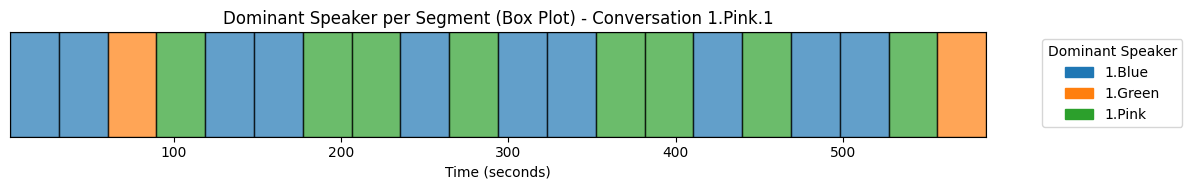

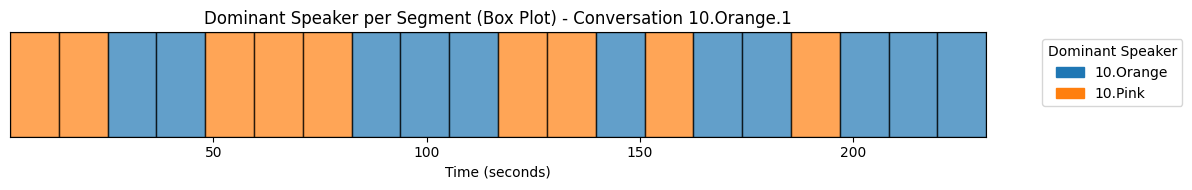

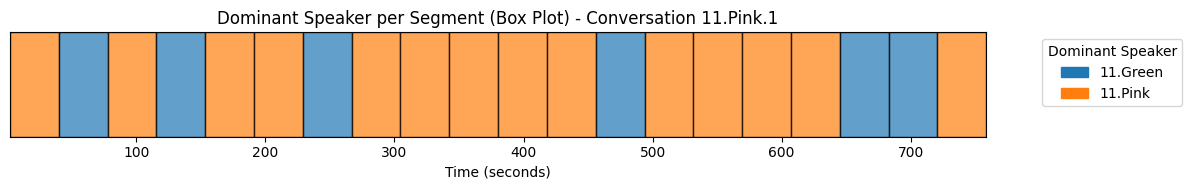

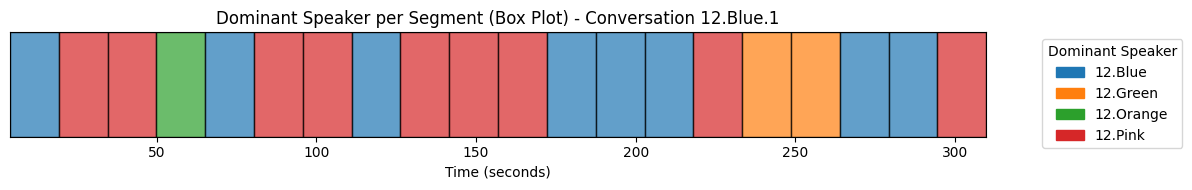

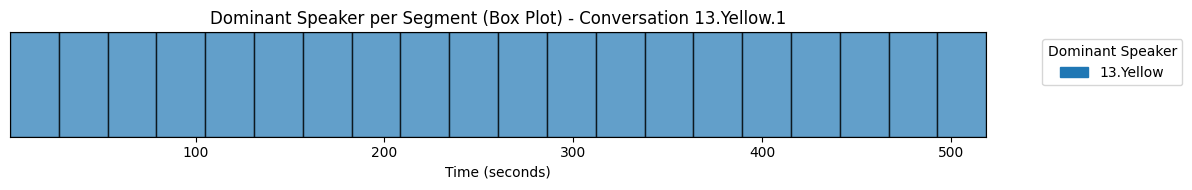

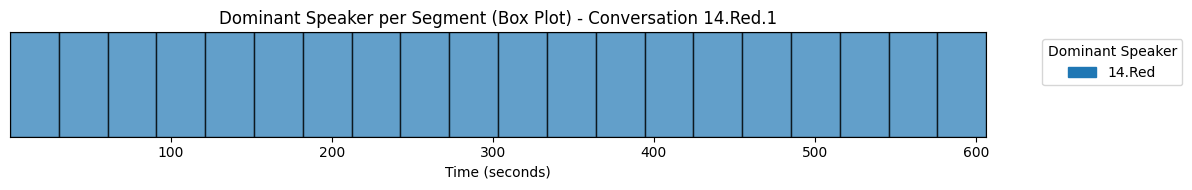

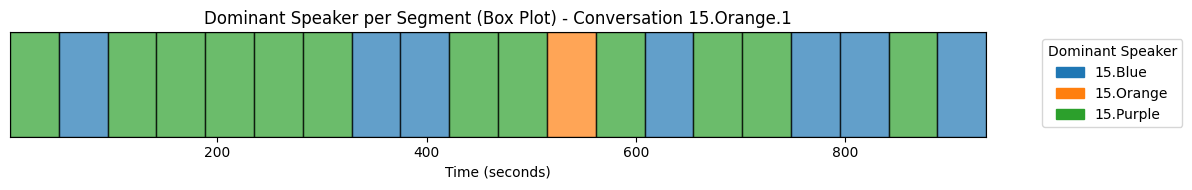

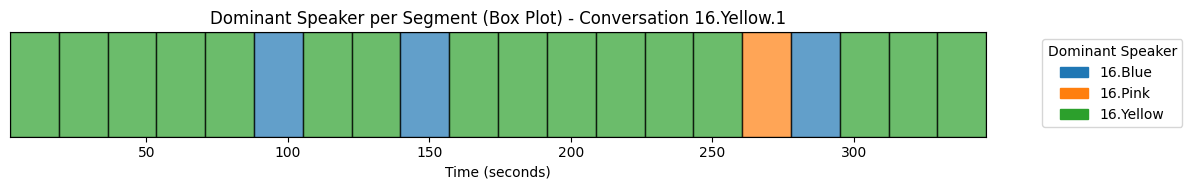

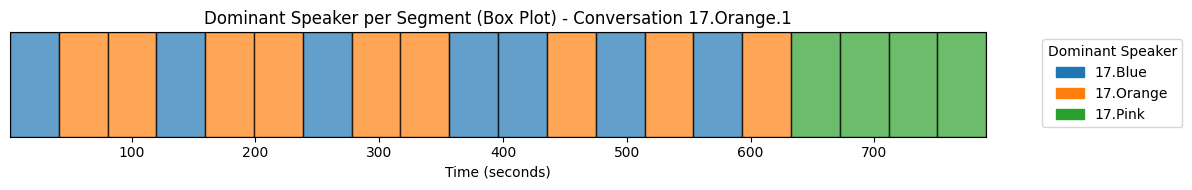

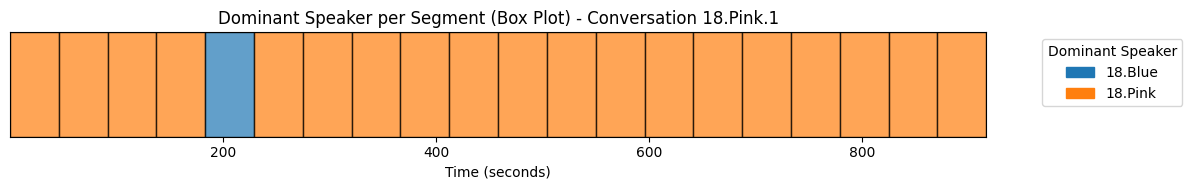

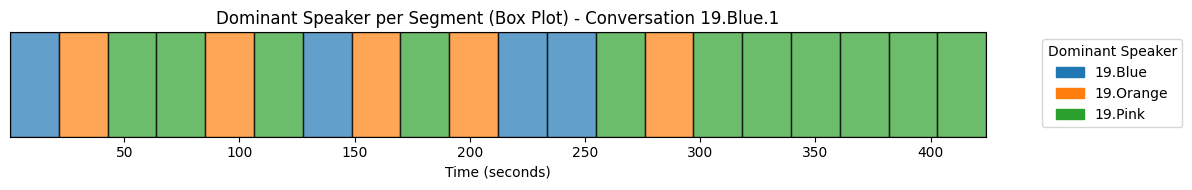

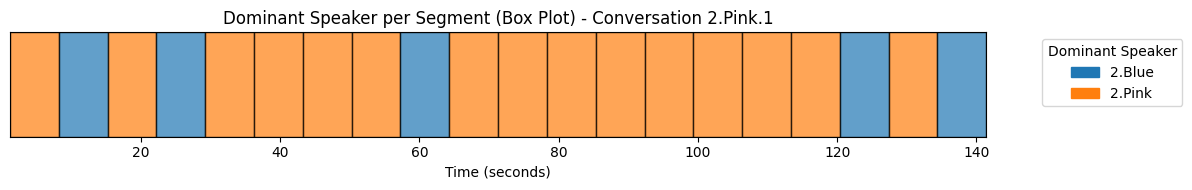

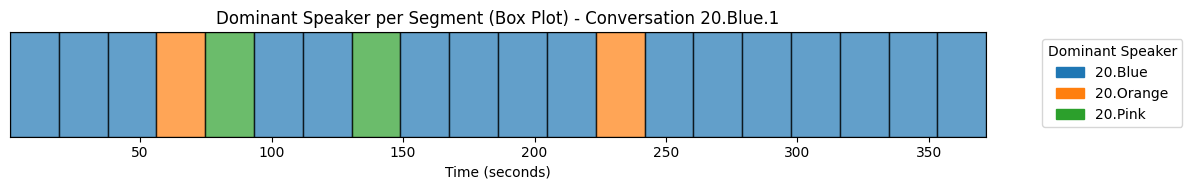

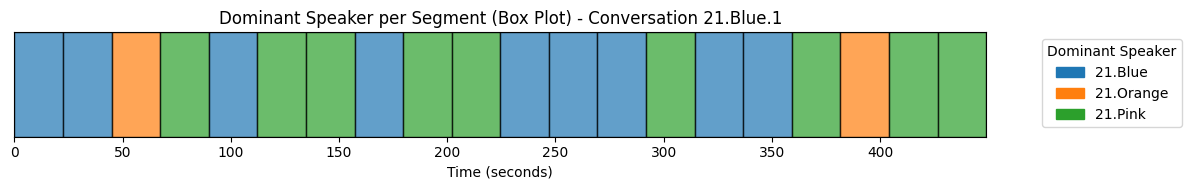

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from convokit import Corpus, download


gap_corpus = Corpus(filename=download("gap-corpus"))
print("Download complete!")

def timestamp_to_seconds(timestamp_str):
    """
    Convert a timestamp in MM:SS.ds format to total seconds.
    """
    try:
        minutes, sec_dec = timestamp_str.split(":")
        return int(minutes) * 60 + float(sec_dec)
    except Exception as e:
        print(f"Error converting timestamp {timestamp_str}: {e}")
        return None

# For each conversation, we:
#   1. Compute the overall start and end times.
#   2. Divide the total duration into 10 equal segments.
#   3. For each segment, calculate the overlap (speaking time) for each speaker.
#   4. Determine the dominant speaker (with maximum overlap) for that segment.
#   5. Display each segment as a box colored by the dominant speaker.

for conv_id, conv in gap_corpus.conversations.items():
    # Filter utterances with both timestamp and Duration metadata.
    utterances = [utt for utt in conv.iter_utterances() if utt.timestamp and utt.meta.get("Duration")]
    if not utterances:
        continue
    
    # Sort utterances chronologically.
    utterances.sort(key=lambda utt: timestamp_to_seconds(utt.timestamp))
    
    # Compute overall conversation start and end times.
    start_times = [timestamp_to_seconds(utt.timestamp) for utt in utterances]
    durations = []
    for utt in utterances:
        try:
            d = float(utt.meta.get("Duration", "1.0"))
        except Exception:
            d = 1.0
        durations.append(d)
    end_times = [s + d for s, d in zip(start_times, durations)]
    conv_start = min(start_times)
    conv_end = max(end_times)
    total_duration = conv_end - conv_start
    if total_duration <= 0:
        continue
    
    # Divide conversation into 10 equal segments.
    seg_length = total_duration / 20.0
    segments = [(conv_start + i * seg_length, conv_start + (i+1) * seg_length) for i in range(20)]
    
    # For each segment, compute the total overlap time per speaker.
    segment_dominants = []  # List of dominant speaker for each segment.
    for seg_start, seg_end in segments:
        speaker_overlap = {}  # key: speaker id, value: total overlapping speaking time in this segment
        for utt in utterances:
            utt_start = timestamp_to_seconds(utt.timestamp)
            try:
                utt_duration = float(utt.meta.get("Duration", "1.0"))
            except Exception:
                utt_duration = 1.0
            utt_end = utt_start + utt_duration
            # Calculate overlap between the utterance and the segment.
            overlap = max(0, min(utt_end, seg_end) - max(utt_start, seg_start))
            if overlap > 0:
                spk = utt.speaker.id
                speaker_overlap[spk] = speaker_overlap.get(spk, 0) + overlap
        # Determine dominant speaker (if any) for the segment.
        if speaker_overlap:
            dominant = max(speaker_overlap.items(), key=lambda x: x[1])[0]
        else:
            dominant = None
        segment_dominants.append(dominant)
    
    # Identify unique dominant speakers in this conversation.
    unique_doms = sorted(set([spk for spk in segment_dominants if spk is not None]))
    if not unique_doms:
        continue
    

    cmap = plt.get_cmap("tab10")
    speaker_colors = {spk: cmap(i % 10) for i, spk in enumerate(unique_doms)}
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_title(f"Dominant Speaker per Segment (Box Plot) - Conversation {conv_id}")
    ax.set_xlabel("Time (seconds)")
    y0 = 0
    height = 1
    
    for i, ((seg_start, seg_end), dom) in enumerate(zip(segments, segment_dominants)):
        color = speaker_colors.get(dom, "lightgray")
        rect = patches.Rectangle((seg_start, y0), seg_length, height,
                                 facecolor=color, edgecolor="black", alpha=0.7)
        ax.add_patch(rect)
    
    ax.set_xlim(conv_start, conv_end)
    ax.set_ylim(0, height)
    ax.set_yticks([])
    handles = [patches.Patch(color=speaker_colors[spk], label=spk) for spk in speaker_colors]
    ax.legend(handles=handles, title="Dominant Speaker", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()
